In [26]:
import torch
import torchvision
import numpy as np
from torch import nn, optim
from torch.utils.data import Subset, DataLoader
import torchvision.transforms as T
from torchvision import datasets, utils, models
import matplotlib.pyplot as plt
import os
from scipy.linalg import norm
from IPython.display import HTML

In [27]:
for folder in ['Results', 'Models']:
    os.makedirs(folder, exist_ok=True)


In [28]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [29]:
LEARNING_RATE = 5e-5
BATCH_SIZE = 64
IMG_SIZE = 64
CHANNELS_IMG = 3
NOISE_DIM = 100
NUM_EPOCHS = 40
FEATURES_DISC = 64
FEATURES_GEN = 64
NUM_CLASSES = 10
EMBED_SIZE = 100
critic_iterations = 5

In [30]:
dataset = datasets.CIFAR10(
    root="./dataset/CIFAR10data",
    download=True,
    transform=T.Compose([
        T.Resize(IMG_SIZE),
        T.ToTensor(),
        T.Normalize((0.5,) * CHANNELS_IMG, (0.5,) * CHANNELS_IMG)
    ])
)


Files already downloaded and verified


In [31]:
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

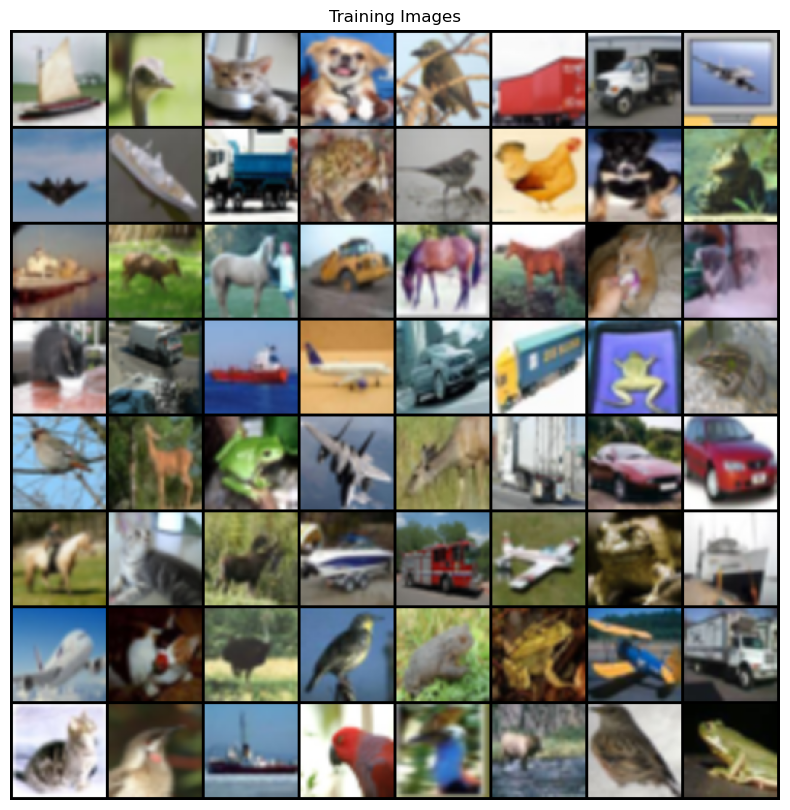

In [32]:
# Visualize a batch of training images
real_batch = next(iter(data_loader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0][:BATCH_SIZE], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [33]:
class Generator(nn.Module):
    def __init__(self, n_classes, img_dim, embed_dim, noise_channels, img_channels, gen_features):
        super(Generator, self).__init__()
        self.image_dimension = img_dim
        self.embedding = nn.Embedding(n_classes, embed_dim)
        self.generator_net = nn.Sequential(
            nn.ConvTranspose2d(noise_channels + embed_dim, gen_features * 16, kernel_size=4, stride=1, padding=0, bias=False),
            self.gen_block(gen_features * 16, gen_features * 8, 4, 2, 1),  # Output: 8x8
            self.gen_block(gen_features * 8, gen_features * 4, 4, 2, 1),  # Output: 16x16
            self.gen_block(gen_features * 4, gen_features * 2, 4, 2, 1),  # Output: 32x32
            nn.ConvTranspose2d(gen_features * 2, img_channels, kernel_size=4, stride=2, padding=1),  # Output: 64x64
            nn.Tanh(),
        )

    def gen_block(self, input_channels, output_channels, kernel, stride, padding):
        # Defines a reusable generator block
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel, stride, padding, bias=False),
            nn.BatchNorm2d(output_channels, momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, noise, labels):
        embeddings = self.embedding(labels).unsqueeze(2).unsqueeze(3)  # Expand dimensions for concatenation
        input_tensor = torch.cat([noise, embeddings], dim=1)  # Concatenate noise and embeddings
        return self.generator_net(input_tensor)



In [34]:
class Discriminator(nn.Module):
    def __init__(self, n_classes, img_dim, img_channels, disc_features):
        super(Discriminator, self).__init__()
        self.disc_net = nn.Sequential(
            nn.Conv2d(img_channels, disc_features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self.disc_block(disc_features, disc_features * 2, 4, 2, 1),
            self.disc_block(disc_features * 2, disc_features * 4, 4, 2, 1),
            self.disc_block(disc_features * 4, disc_features * 8, 4, 2, 1),
        )
        self.validity = nn.Sequential(
            nn.Conv2d(disc_features * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
        self.label_prediction = nn.Sequential(
            nn.Conv2d(disc_features * 8, n_classes + 1, kernel_size=4, stride=1, padding=0, bias=False),  # For class prediction
            nn.LogSoftmax(dim=1)
        )
        self.label_embed = nn.Embedding(n_classes, img_dim * img_dim)

    def disc_block(self, input_channels, output_channels, kernel, stride, padding):
        # Defines a reusable discriminator block
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel, stride, padding, bias=False),
            nn.LeakyReLU(0.2),
        )

    def forward(self, image):
        features = self.disc_net(image)
        validity = self.validity(features).view(-1)  # Validity score
        label_logits = self.label_prediction(features).view(-1, 11)  # Label logits for classes
        return validity, label_logits



In [35]:
def initialize_weights(network):
    # Initializes weights for Conv2d, ConvTranspose2d, and BatchNorm2d layers
    for layer in network.modules():
        if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(layer.weight.data, mean=0.0, std=0.02)



In [36]:
# Define IMAGE_SIZE
IMAGE_SIZE = 64
# Instantiate Generator and Discriminator
generator = Generator(NUM_CLASSES, IMAGE_SIZE, EMBED_SIZE, NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
discriminator = Discriminator(NUM_CLASSES, IMAGE_SIZE, CHANNELS_IMG, FEATURES_DISC).to(device)

# Initialize weights for both models
initialize_weights(generator)
initialize_weights(discriminator)

# Set models to training mode
generator.train()


Generator(
  (embedding): Embedding(10, 100)
  (generator_net): Sequential(
    (0): ConvTranspose2d(200, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)

In [37]:
discriminator.train()

Discriminator(
  (disc_net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (validity): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): Sigmoid()
  )
  (label_prediction): Sequential(
    (0): Conv2d(512, 11, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): LogSoftmax(dim=1)
  )
  (label_embed): Embedding(10, 4096)
)

In [43]:

import torch
import torch.nn as nn
import torch.nn.functional as F  # Ensure this is imported
from torchvision import models
from torchvision.models import Inception_V3_Weights
import numpy as np
from scipy.linalg import sqrtm
class CustomInceptionV3(nn.Module):
    """Modified Pretrained InceptionV3 for feature extraction."""

    DEFAULT_OUTPUT_INDEX = 3

    OUTPUT_DIM_TO_INDEX = {
        64: 0,    # Features after first max pooling
        192: 1,   # Features after second max pooling
        768: 2,   # Pre-aux classifier features
        2048: 3   # Final pooling layer
    }

    def __init__(self, output_indices=[DEFAULT_OUTPUT_INDEX], resize_input=True, normalize_input=True, trainable=False):
        super(CustomInceptionV3, self).__init__()
        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_indices = sorted(output_indices)
        self.final_index = max(output_indices)

        assert self.final_index <= 3, "Final block index cannot exceed 3."

        inception_model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        self.feature_blocks = nn.ModuleList()

        # Feature Block 0
        self.feature_blocks.append(
            nn.Sequential(
                inception_model.Conv2d_1a_3x3,
                inception_model.Conv2d_2a_3x3,
                inception_model.Conv2d_2b_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            )
        )

        # Feature Block 1
        if self.final_index >= 1:
            self.feature_blocks.append(
                nn.Sequential(
                    inception_model.Conv2d_3b_1x1,
                    inception_model.Conv2d_4a_3x3,
                    nn.MaxPool2d(kernel_size=3, stride=2)
                )
            )

        # Feature Block 2
        if self.final_index >= 2:
            self.feature_blocks.append(
                nn.Sequential(
                    inception_model.Mixed_5b,
                    inception_model.Mixed_5c,
                    inception_model.Mixed_5d,
                    inception_model.Mixed_6a,
                    inception_model.Mixed_6b,
                    inception_model.Mixed_6c,
                    inception_model.Mixed_6d,
                    inception_model.Mixed_6e
                )
            )

        # Feature Block 3
        if self.final_index >= 3:
            self.feature_blocks.append(
                nn.Sequential(
                    inception_model.Mixed_7a,
                    inception_model.Mixed_7b,
                    inception_model.Mixed_7c,
                    nn.AdaptiveAvgPool2d(output_size=(1, 1))
                )
            )

        for param in self.parameters():
            param.requires_grad = trainable

    def forward(self, x):
        outputs = []

        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Normalize from (0,1) to (-1,1)

        for idx, block in enumerate(self.feature_blocks):
            x = block(x)
            if idx in self.output_indices:
                outputs.append(x)
            if idx == self.final_index:
                break

        return outputs


def calculate_stats(images, model, batch_size=128, dims=2048, use_cuda=False):
    """Calculate mean and covariance of activations."""
    model.eval()
    activations = np.empty((len(images), dims))

    if use_cuda:
        images = images.cuda()

    predictions = model(images)[0]

    # Global average pooling for spatial dimensions
    if predictions.size(2) != 1 or predictions.size(3) != 1:
        predictions = F.adaptive_avg_pool2d(predictions, output_size=(1, 1))

    activations = predictions.cpu().data.numpy().reshape(predictions.size(0), -1)
    mean = np.mean(activations, axis=0)
    covariance = np.cov(activations, rowvar=False)

    return mean, covariance


def frechet_distance(mean1, cov1, mean2, cov2, epsilon=1e-6):
    """Compute the Frechet Distance between two Gaussians."""
    mean1, mean2 = np.atleast_1d(mean1), np.atleast_1d(mean2)
    cov1, cov2 = np.atleast_2d(cov1), np.atleast_2d(cov2)

    assert mean1.shape == mean2.shape, "Mean vectors must have the same length."
    assert cov1.shape == cov2.shape, "Covariance matrices must have the same dimensions."

    diff = mean1 - mean2
    sqrt_cov_product, _ = sqrtm(cov1.dot(cov2), disp=False)

    if not np.isfinite(sqrt_cov_product).all():
        offset = np.eye(cov1.shape[0]) * epsilon
        sqrt_cov_product = sqrtm((cov1 + offset).dot(cov2 + offset))

    if np.iscomplexobj(sqrt_cov_product):
        sqrt_cov_product = sqrt_cov_product.real

    trace_sqrt_cov_product = np.trace(sqrt_cov_product)
    return diff.dot(diff) + np.trace(cov1) + np.trace(cov2) - 2 * trace_sqrt_cov_product


def compute_fid(real_images, fake_images, model):
    """Calculate the Frechet Inception Distance."""
    mean_real, cov_real = calculate_stats(real_images, model, use_cuda=True)
    mean_fake, cov_fake = calculate_stats(fake_images, model, use_cuda=True)
    return frechet_distance(mean_real, cov_real, mean_fake, cov_fake)


# Instantiate the model
block_index = CustomInceptionV3.OUTPUT_DIM_TO_INDEX[2048]
inception_model = CustomInceptionV3([block_index]).cuda()

# Example real and fake images (replace these with your actual tensors)
real_images = torch.randn(16, 3, 299, 299).cuda()  # Replace with actual images
fake_images = torch.randn(16, 3, 299, 299).cuda()  # Replace with generated images

# Compute FID
fid_value = compute_fid(real_images, fake_images, inception_model)
print("FID Value:", fid_value)


FID Value: 28.192984930660774


In [50]:
import time 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Dataset and DataLoader
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),  # Resize images to match the input size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.5,) * CHANNELS_IMG, (0.5,) * CHANNELS_IMG)  # Normalize between -1 and 1
])

# Load the CIFAR10 dataset as an example
dataset = torchvision.datasets.CIFAR10(
    root="./dataset/CIFAR10data", 
    download=True, 
    transform=transform
)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Instantiate Generator and Discriminator
gen = Generator(NUM_CLASSES, IMAGE_SIZE, EMBED_SIZE, NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(NUM_CLASSES, IMAGE_SIZE, CHANNELS_IMG, FEATURES_DISC).to(device)

# Initialize weights
initialize_weights(gen)
initialize_weights(disc)

# Define optimizers
disOptim = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
genOptim = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

# Other variables
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
step = 0
counterList, GenLoss, DiscLoss, img_list, FID_list = [], [], [], [], []

print("Models and optimizers are initialized!")




fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
step = 0
disOptim = optim.Adam(disc.parameters(), LEARNING_RATE, betas=(0.5, 0.999))
genOptim = optim.Adam(gen.parameters(), LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()
GenLoss, DiscLoss, FID_list = [], [], []
img_list = []
iters = 0




# Start timing
time_start = time.time()

print("!! Training Started !!")

# Main training loop
for epoch in range(1, NUM_EPOCHS + 1):
    for batch_idx, (realImg, labels) in enumerate(dataloader):
        real = realImg.to(device)
        labels = labels.to(device)
        miniBatch = real.size(0)

        # Labels for real and fake images
        real_labels = torch.full((miniBatch,), 1.0, dtype=torch.float).to(device)
        fake_labels = torch.full((miniBatch,), 0.0, dtype=torch.float).to(device)

        ##########################
        ### Train Discriminator ###
        ##########################
        disc.zero_grad()

        # Discriminator loss for real images
        disc_real, disc_label = disc(real)
        loss_real_val = criterion(disc_real, real_labels)
        loss_real_label = F.nll_loss(disc_label, labels)
        loss_real = loss_real_val + loss_real_label
        loss_real.backward()

        # Discriminator loss for fake images
        noise = torch.randn(miniBatch, NOISE_DIM, 1, 1).to(device)
        sample_labels = torch.randint(0, NUM_CLASSES, (miniBatch,), dtype=torch.long).to(device)
        fake_images = gen(noise, sample_labels)
        disc_fake, disc_fake_label = disc(fake_images.detach())
        loss_fake_val = criterion(disc_fake, fake_labels)
        fake_class_label = torch.full_like(sample_labels, NUM_CLASSES).to(device)  # Fake class index
        loss_fake_label = F.nll_loss(disc_fake_label, fake_class_label)
        loss_fake = loss_fake_val + loss_fake_label
        loss_fake.backward()

        # Update discriminator
        loss_disc = (loss_real + loss_fake) / 2
        disOptim.step()

        #######################
        ### Train Generator ###
        #######################
        gen.zero_grad()

        # Generate fake images
        gen_output, gen_output_label = disc(fake_images)
        loss_gen_val = criterion(gen_output, real_labels)
        loss_gen_label = F.nll_loss(gen_output_label, sample_labels)
        loss_gen = loss_gen_val + loss_gen_label
        loss_gen.backward()

        # Update generator
        genOptim.step()

        # Save losses
        GenLoss.append(loss_gen.item())
        DiscLoss.append(loss_disc.item())

        # Save generated images periodically
        if (iters % 500 == 0) or (epoch == NUM_EPOCHS and batch_idx == len(dataloader) - 1):
            with torch.no_grad():
                # Dynamically adjust noise to match the batch size of labels
                current_batch_size = labels.size(0)  # Use labels' size as reference
                dynamic_noise = torch.randn(current_batch_size, NOISE_DIM, 1, 1).to(device)  # Dynamically generate noise
                fake = gen(dynamic_noise, labels).detach().cpu()  # Use the dynamically generated noise
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))

        

        iters += 1

    ###################
    ### Compute FID ###
    ###################
    fid_value = compute_fid(real, fake_images, inception_model)
    FID_list.append(fid_value)

    # Print stats periodically
    if epoch % 5 == 0:
        print(f"Epoch [{epoch}/{NUM_EPOCHS}] | Discriminator Loss: {loss_disc:.3f} | Generator Loss: {loss_gen:.3f} | FID Score: {fid_value:.3f}")

    ###########################
    ### Save Generated Images ###
    ###########################
    os.makedirs('Results/ACGAN_FAKE', exist_ok=True)
    os.makedirs('Results/ACGAN_REAL', exist_ok=True)
    with torch.no_grad():
        fake_images_epoch = gen(noise, sample_labels).detach()
    utils.save_image(fake_images_epoch, f'Results/ACGAN_FAKE/ACGAN_epoch_{epoch:03d}.png', normalize=True)
    utils.save_image(real, f'Results/ACGAN_REAL/ACGAN_epoch_{epoch:03d}.png', normalize=True)

    ########################
    ### Save Model Checkpoints ###
    ########################
    if epoch % 10 == 0:
        torch.save(gen.state_dict(), f'Models/Generator_epoch_{epoch:03d}.pth')
        torch.save(disc.state_dict(), f'Models/Discriminator_epoch_{epoch:03d}.pth')

time_end = time.time()
print(f'\n\nElapsed Time: {time_end - time_start:.2f} seconds.')


Files already downloaded and verified
Models and optimizers are initialized!
!! Training Started !!
Epoch [5/40] | Discriminator Loss: 1.939 | Generator Loss: 2.880 | FID Score: 338.213
Epoch [10/40] | Discriminator Loss: 1.948 | Generator Loss: 2.508 | FID Score: 363.131
Epoch [15/40] | Discriminator Loss: 1.760 | Generator Loss: 3.002 | FID Score: 386.125
Epoch [20/40] | Discriminator Loss: 1.603 | Generator Loss: 3.033 | FID Score: 302.344
Epoch [25/40] | Discriminator Loss: 1.714 | Generator Loss: 3.767 | FID Score: 309.774
Epoch [30/40] | Discriminator Loss: 1.410 | Generator Loss: 2.941 | FID Score: 307.974
Epoch [35/40] | Discriminator Loss: 1.665 | Generator Loss: 2.906 | FID Score: 314.559
Epoch [40/40] | Discriminator Loss: 1.574 | Generator Loss: 3.935 | FID Score: 292.291


Elapsed Time: 622.16 seconds.


In [51]:
print("Saving loss data...")

# Ensure the directory exists
if not os.path.exists('Results/Loss_Data'):
    os.makedirs('Results/Loss_Data')

# Save generator and discriminator losses
np.save('Results/Loss_Data/ACGAN_GLoss.npy', GenLoss)
np.save('Results/Loss_Data/ACGAN_DLoss.npy', DiscLoss)

print("Loss data saved successfully!")

Saving loss data...
Loss data saved successfully!


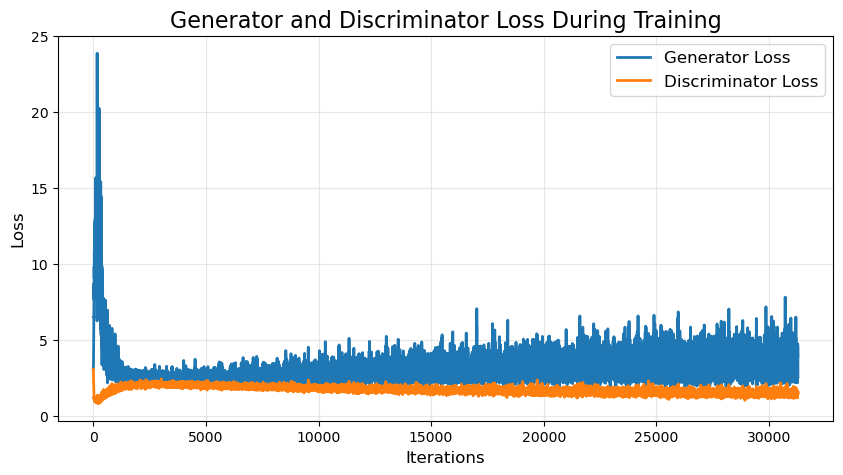

In [52]:
# Paths to loss data files
gen_loss_path = 'Results/Loss_Data/ACGAN_GLoss.npy'
disc_loss_path = 'Results/Loss_Data/ACGAN_DLoss.npy'

# Check if files exist
if not (os.path.exists(gen_loss_path) and os.path.exists(disc_loss_path)):
    raise FileNotFoundError("Loss data files not found. Ensure ACGAN_GLoss.npy and ACGAN_DLoss.npy exist.")

# Load loss data
GenLoss = np.load(gen_loss_path)
DiscLoss = np.load(disc_loss_path)

# Plot loss data
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training", fontsize=16)
plt.plot(GenLoss, label="Generator Loss", linewidth=2)
plt.plot(DiscLoss, label="Discriminator Loss", linewidth=2)
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Save the plot as a PDF
os.makedirs('Results', exist_ok=True)
plt.savefig('Results/LOSS_AC.pdf', format='pdf', dpi=100, bbox_inches='tight')

# Show the plot
plt.show()


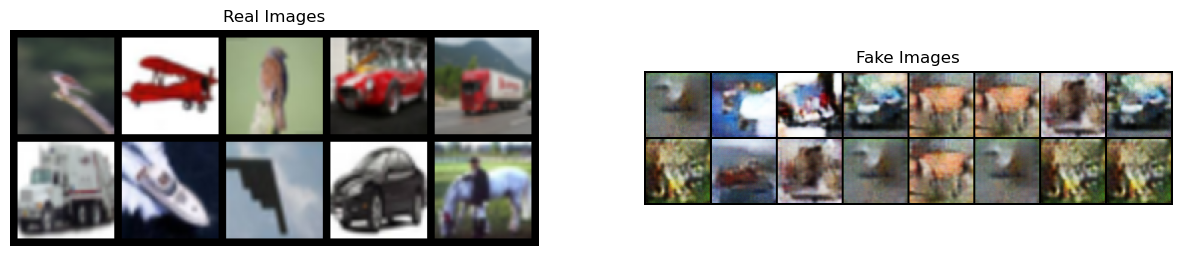

In [53]:

from torchvision.utils import make_grid

# Check if img_list is populated
if len(img_list) == 0:
    raise ValueError("img_list is empty. Ensure that the training loop has run and generated fake images.")

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real and fake images
plt.figure(figsize=(15, 15))

# Real Images
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:10], nrow=5, padding=5, normalize=True).cpu(), (1, 2, 0)))

# Fake Images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1].cpu(), (1, 2, 0)))

# Save the plot
os.makedirs('Results', exist_ok=True)
plt.savefig('Results/ACGAN_BEST_FAKE_32.pdf', format='pdf', dpi=100, bbox_inches='tight')

# Show the plot
plt.show()


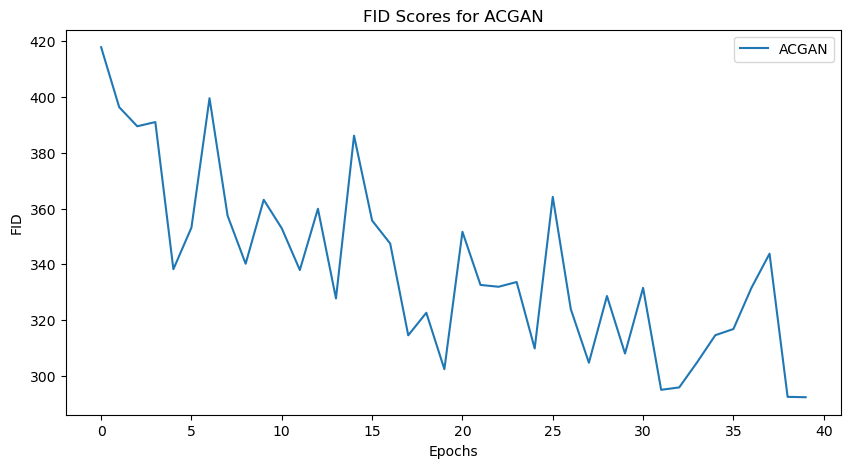

In [54]:
# Plot FID Scores
plt.figure(figsize=(10, 5))
plt.title("FID Scores for ACGAN")
plt.plot(FID_list, label="ACGAN")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()

# Save the FID plot
os.makedirs('Results', exist_ok=True)  # Ensure Results directory exists
plt.savefig('Results/FID.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [55]:
# Save FID scores
os.makedirs('Results/FID_score', exist_ok=True)  # Ensure FID_score directory exists
np.save('Results/FID_score/ACGAN_FID.npy', FID_list)

# Display FID statistics
min_fid = np.min(FID_list)
max_fid = np.max(FID_list)
mean_fid = np.mean(FID_list)
last_five_fid = FID_list[-5:]
print(f"FID Statistics: Min: {min_fid}, Max: {max_fid}, Mean: {mean_fid}, Last 5 FID scores: {last_five_fid}")


FID Statistics: Min: 292.290865369198, Max: 417.86658141011367, Mean: 339.0243716361746, Last 5 FID scores: [316.75568360719757, 331.56087041104956, 343.78665877277444, 292.42310993796673, 292.290865369198]


In [59]:
# Display Generator and Discriminator Loss Statistics
mean_gen_loss = np.mean(GenLoss)
mean_disc_loss = np.mean(DiscLoss)
min_gen_loss = np.min(GenLoss)
min_disc_loss = np.min(DiscLoss)
last_gen_loss = GenLoss[-1]
last_disc_loss = DiscLoss[-1]
print(f"Generator Loss: Mean: {mean_gen_loss}, Min: {min_gen_loss}, Last: {last_gen_loss}")
print(f"Discriminator Loss: Mean: {mean_disc_loss}, Min: {min_disc_loss}, Last: {last_disc_loss}")

Generator Loss: Mean: 3.1947489839914205, Min: 1.594935655593872, Last: 3.934670925140381
Discriminator Loss: Mean: 1.7366360036765829, Min: 0.864444375038147, Last: 1.5735697746276855


In [57]:
np.min(FID_list), np.max(FID_list), np.mean(FID_list), FID_list[-5]

(292.290865369198, 417.86658141011367, 339.0243716361746, 316.75568360719757)

In [58]:
np.mean(GenLoss),np.mean(DiscLoss),np.min(GenLoss),np.min(DiscLoss),GenLoss[-1],DiscLoss[-1]

(3.1947489839914205,
 1.7366360036765829,
 1.594935655593872,
 0.864444375038147,
 3.934670925140381,
 1.5735697746276855)